In [2]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks, reduce_to_skill

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-14 09:23:50.123465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-14 09:23:50.123495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4, use_jmeasure=False)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-11 17:05:40.927006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 17:05:40.927040: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 17:05:40.927065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-11 17:05:40.927264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 17:05:40.978571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optim

41/41 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.5498 - brier: 0.2597 - val_loss: 0.7860 - val_accuracy: 0.4826 - val_brier: 0.2891
Epoch 2/200
41/41 [==============================] - 0s 997us/step - loss: 0.7235 - accuracy: 0.5498 - brier: 0.2584 - val_loss: 0.7838 - val_accuracy: 0.4826 - val_brier: 0.2883
Epoch 3/200
41/41 [==============================] - 0s 999us/step - loss: 0.7196 - accuracy: 0.5653 - brier: 0.2565 - val_loss: 0.7804 - val_accuracy: 0.4826 - val_brier: 0.2870
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5793 - brier: 0.2532 - val_loss: 0.7752 - val_accuracy: 0.4905 - val_brier: 0.2848
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7018 - accuracy: 0.5793 - brier: 0.2485 - val_loss: 0.7684 - val_accuracy: 0.4968 - val_brier: 0.2819
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5972 - brier: 0.2419 - val_lo

41/41 [==============================] - 0s 1ms/step - loss: 0.5331 - accuracy: 0.7589 - brier: 0.1705 - val_loss: 0.6244 - val_accuracy: 0.6356 - val_brier: 0.2191
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5319 - accuracy: 0.7621 - brier: 0.1697 - val_loss: 0.6212 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 49/200
41/41 [==============================] - 0s 996us/step - loss: 0.5316 - accuracy: 0.7628 - brier: 0.1697 - val_loss: 0.6214 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.7566 - brier: 0.1699 - val_loss: 0.6216 - val_accuracy: 0.6341 - val_brier: 0.2182
Epoch 51/200
41/41 [==============================] - 0s 991us/step - loss: 0.5319 - accuracy: 0.7589 - brier: 0.1697 - val_loss: 0.6237 - val_accuracy: 0.6341 - val_brier: 0.2186
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7613 - brier: 0.1696 - v

In [3]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [4]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [5]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [6]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

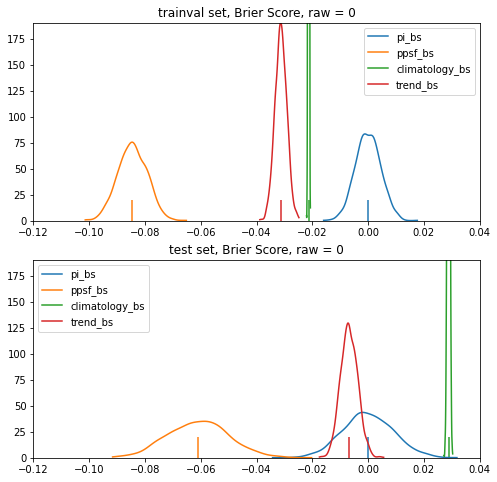

In [7]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

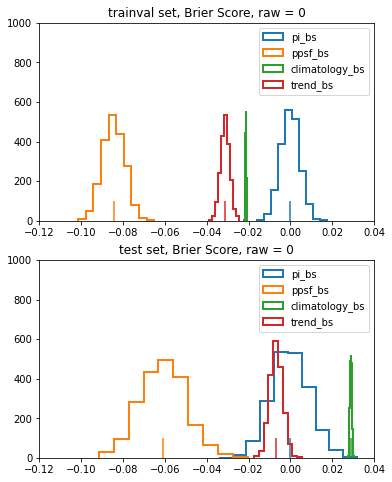

In [15]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (6,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [9]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

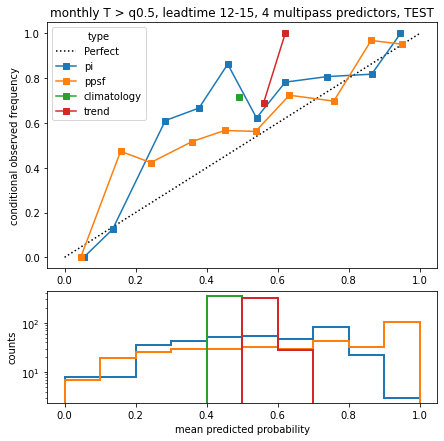

In [14]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

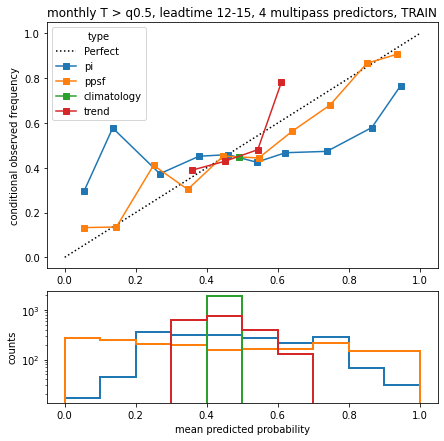

In [13]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TRAIN')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. Currently post-processed combinations are not post-processed with jmeasure input.

In [12]:
def extra_scores_and_skill(df):
    compute_kss(df)
    compute_auc(df)
    return reduce_to_skill(df)

In [13]:
# Handle all the tganom post-processed combinations with objective sequential forward predictors.
# And with the jmeasure data
# We will only look at test data.
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
npreds = pd.Series([4,3,4,6,4,4,4,12], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%
def get_tganom_predictions(timeagg: int, quantile: float):
    name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15'
    _, test_sf = build_fit_nn_model(predictandname = name, npreds = npreds.loc[(timeagg,quantile)], use_jmeasure=False)
    _, test_jm = build_fit_nn_model(predictandname = name, npreds = 6, use_jmeasure=True)
    return test_sf, test_jm
results = []
for timeagg, quantile in npreds.index:
    test_sf, test_jm = get_tganom_predictions(timeagg, quantile)
    agg_scores = extra_scores_and_skill(test_sf.join(test_jm[['ppjm','ppjm_bs']]))
    results.append(agg_scores)
ranktganom = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5910 - brier: 0.2497 - val_loss: 0.7328 - val_accuracy: 0.5126 - val_brier: 0.2667
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.6198 - brier: 0.2367 - val_loss: 0.6908 - val_accuracy: 0.5300 - val_brier: 0.2492
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6346 - accuracy: 0.6664 - brier: 0.2200 - val_loss: 0.6562 - val_accuracy: 0.5820 - val_brier: 0.2340
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6065 - accuracy: 0.6866 - brier: 0.2078 - val_loss: 0.6284 - val_accuracy: 0.6199 - val_brier: 0.2218
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5881 - accuracy: 0.6866 - brier: 0.2001 - val_loss: 0.6091 - val_accuracy: 0.6356 - val_brier: 0.2134
Epoch 6/200
41/41 [==============================] -

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 1s 3ms/step - loss: 0.5797 - accuracy: 0.7170 - brier: 0.1939 - val_loss: 0.7019 - val_accuracy: 0.6246 - val_brier: 0.2438
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5617 - accuracy: 0.7395 - brier: 0.1847 - val_loss: 0.6764 - val_accuracy: 0.6199 - val_brier: 0.2366
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5413 - accuracy: 0.7551 - brier: 0.1770 - val_loss: 0.6600 - val_accuracy: 0.6830 - val_brier: 0.2270
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.7667 - brier: 0.1681 - val_loss: 0.6331 - val_accuracy: 0.6656 - val_brier: 0.2179
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5106 - accuracy: 0.7760 - brier: 0.1631 - val_loss: 0.6304 - val_accuracy: 0.6830 - val_brier: 0.2145
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5002 - accuracy: 0.7846 - brier: 0.1579 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4538 - accuracy: 0.8142 - brier: 0.1433 - val_loss: 0.6201 - val_accuracy: 0.7256 - val_brier: 0.2036
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.8235 - brier: 0.1362 - val_loss: 0.5994 - val_accuracy: 0.7397 - val_brier: 0.1957
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4031 - accuracy: 0.8274 - brier: 0.1254 - val_loss: 0.5745 - val_accuracy: 0.7413 - val_brier: 0.1888
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3729 - accuracy: 0.8383 - brier: 0.1140 - val_loss: 0.5582 - val_accuracy: 0.7603 - val_brier: 0.1817
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3518 - accuracy: 0.8484 - brier: 0.1065 - val_loss: 0.5414 - val_accuracy: 0.7413 - val_brier: 0.1775
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3368 - accuracy: 0.8600 - brier: 0.1011 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.9199 - brier: 0.0712 - val_loss: 0.2933 - val_accuracy: 0.9196 - val_brier: 0.0759
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2555 - accuracy: 0.9207 - brier: 0.0693 - val_loss: 0.2901 - val_accuracy: 0.9164 - val_brier: 0.0747
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2467 - accuracy: 0.9207 - brier: 0.0676 - val_loss: 0.2853 - val_accuracy: 0.9164 - val_brier: 0.0731
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2334 - accuracy: 0.9199 - brier: 0.0646 - val_loss: 0.2791 - val_accuracy: 0.9196 - val_brier: 0.0705
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2181 - accuracy: 0.9191 - brier: 0.0610 - val_loss: 0.2744 - val_accuracy: 0.9211 - val_brier: 0.0690
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2045 - accuracy: 0.9230 - brier: 0.0575 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.7204 - accuracy: 0.5669 - brier: 0.2569 - val_loss: 0.7741 - val_accuracy: 0.4858 - val_brier: 0.2844
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6839 - accuracy: 0.6089 - brier: 0.2398 - val_loss: 0.7451 - val_accuracy: 0.5174 - val_brier: 0.2720
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6351 - accuracy: 0.6649 - brier: 0.2172 - val_loss: 0.7120 - val_accuracy: 0.5331 - val_brier: 0.2577
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5987 - accuracy: 0.7061 - brier: 0.2007 - val_loss: 0.6903 - val_accuracy: 0.5584 - val_brier: 0.2484
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7138 - brier: 0.1923 - val_loss: 0.6739 - val_accuracy: 0.5931 - val_brier: 0.2407
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5659 - accuracy: 0.7348 - brier: 0.1853 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5552 - accuracy: 0.7403 - brier: 0.1831 - val_loss: 0.7277 - val_accuracy: 0.6388 - val_brier: 0.2509
Epoch 2/200
41/41 [==============================] - 0s 998us/step - loss: 0.5349 - accuracy: 0.7519 - brier: 0.1753 - val_loss: 0.7062 - val_accuracy: 0.6483 - val_brier: 0.2432
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5091 - accuracy: 0.7597 - brier: 0.1660 - val_loss: 0.6905 - val_accuracy: 0.6798 - val_brier: 0.2345
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4890 - accuracy: 0.7675 - brier: 0.1585 - val_loss: 0.6708 - val_accuracy: 0.6656 - val_brier: 0.2291
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7854 - brier: 0.1528 - val_loss: 0.6723 - val_accuracy: 0.6956 - val_brier: 0.2231
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.7830 - brier: 0.1485 - val_loss

41/41 [==============================] - 0s 1ms/step - loss: 0.4138 - accuracy: 0.8165 - brier: 0.1320 - val_loss: 0.6251 - val_accuracy: 0.7429 - val_brier: 0.1996
Epoch 33/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4133 - accuracy: 0.8173 - brier: 0.1318 - val_loss: 0.6305 - val_accuracy: 0.7492 - val_brier: 0.2010
Epoch 34/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4131 - accuracy: 0.8118 - brier: 0.1317 - val_loss: 0.6045 - val_accuracy: 0.7397 - val_brier: 0.1946
Epoch 35/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4150 - accuracy: 0.8126 - brier: 0.1326 - val_loss: 0.6336 - val_accuracy: 0.7382 - val_brier: 0.2016
Epoch 36/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4101 - accuracy: 0.8157 - brier: 0.1307 - val_loss: 0.6222 - val_accuracy: 0.7382 - val_brier: 0.1987
Epoch 37/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4108 - accuracy: 0.8173 - brier: 0.1310 - val_l

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4276 - accuracy: 0.8344 - brier: 0.1320 - val_loss: 0.6207 - val_accuracy: 0.7603 - val_brier: 0.1984
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4096 - accuracy: 0.8359 - brier: 0.1259 - val_loss: 0.6008 - val_accuracy: 0.7587 - val_brier: 0.1915
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3800 - accuracy: 0.8546 - brier: 0.1153 - val_loss: 0.5787 - val_accuracy: 0.7524 - val_brier: 0.1823
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3491 - accuracy: 0.8670 - brier: 0.1045 - val_loss: 0.5477 - val_accuracy: 0.7681 - val_brier: 0.1713
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3315 - accuracy: 0.8779 - brier: 0.0984 - val_loss: 0.5376 - val_accuracy: 0.7839 - val_brier: 0.1668
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3170 - accuracy: 0.8849 - brier: 0.0937 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.2563 - accuracy: 0.9238 - brier: 0.0684 - val_loss: 0.3182 - val_accuracy: 0.8959 - val_brier: 0.0869
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2424 - accuracy: 0.9238 - brier: 0.0654 - val_loss: 0.3174 - val_accuracy: 0.8943 - val_brier: 0.0860
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy: 0.9238 - brier: 0.0612 - val_loss: 0.3175 - val_accuracy: 0.8943 - val_brier: 0.0856
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.9269 - brier: 0.0555 - val_loss: 0.3098 - val_accuracy: 0.8959 - val_brier: 0.0830
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1814 - accuracy: 0.9331 - brier: 0.0500 - val_loss: 0.2909 - val_accuracy: 0.9069 - val_brier: 0.0776
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.1673 - accuracy: 0.9417 - brier: 0.0459 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [14]:
# Handle the tg-ex postprocessed. Test_only.
ndaythresh = [5,7,9,11]
npreds = pd.Series([6,8,11,8], index = pd.Index(ndaythresh, name = 'nday_threshold'))
results = []
for th in ndaythresh:
    name = f'tg-ex-q0.75-21D_ge{th}D_sep12-15'
    _, test_sf = build_fit_nn_model(predictandname = name, npreds = npreds.loc[th], use_jmeasure=False)
    _, test_jm = build_fit_nn_model(predictandname = name, npreds = 6, use_jmeasure=True)
    agg_scores = extra_scores_and_skill(test_sf.join(test_jm[['ppjm','ppjm_bs']]))
    results.append(agg_scores)
ranktgex = pd.concat(results, axis = 1, keys = npreds.index).T

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7356 - accuracy: 0.5373 - brier: 0.2648 - val_loss: 0.7958 - val_accuracy: 0.4511 - val_brier: 0.2912
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7177 - accuracy: 0.5622 - brier: 0.2570 - val_loss: 0.7914 - val_accuracy: 0.4653 - val_brier: 0.2887
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5809 - brier: 0.2471 - val_loss: 0.7592 - val_accuracy: 0.5047 - val_brier: 0.2749
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6686 - accuracy: 0.5995 - brier: 0.2352 - val_loss: 0.6924 - val_accuracy: 0.5789 - val_brier: 0.2466
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6447 - accuracy: 0.6291 - brier: 0.2244 - val_loss: 0.6586 - val_accuracy: 0.6104 - val_brier: 0.2317
Epoch 6/200
41/41 [==============================] -

Epoch 47/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5215 - accuracy: 0.7613 - brier: 0.1695 - val_loss: 0.5143 - val_accuracy: 0.7871 - val_brier: 0.1684
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200
41/41 [==============================] - 0s 3ms/step - loss: 0.7340 - accuracy: 0.5404 - brier: 0.2639 - val_loss: 0.8180 - val_accuracy: 0.4322 - val_brier: 0.2999
Ep

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.5562 - accuracy: 0.7333 - brier: 0.1861 - val_loss: 0.6635 - val_accuracy: 0.6735 - val_brier: 0.2259
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5188 - accuracy: 0.7496 - brier: 0.1714 - val_loss: 0.6215 - val_accuracy: 0.6909 - val_brier: 0.2114
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.7970 - brier: 0.1498 - val_loss: 0.5689 - val_accuracy: 0.7508 - val_brier: 0.1888
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4272 - accuracy: 0.8002 - brier: 0.1351 - val_loss: 0.5349 - val_accuracy: 0.7744 - val_brier: 0.1753
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3999 - accuracy: 0.8297 - brier: 0.1247 - val_loss: 0.5077 - val_accuracy: 0.7839 - val_brier: 0.1646
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3817 - accuracy: 0.8305 - brier: 0.1181 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.4318 - accuracy: 0.8243 - brier: 0.1349 - val_loss: 0.5173 - val_accuracy: 0.7965 - val_brier: 0.1584
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4124 - accuracy: 0.8297 - brier: 0.1286 - val_loss: 0.5254 - val_accuracy: 0.7886 - val_brier: 0.1661
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3842 - accuracy: 0.8359 - brier: 0.1190 - val_loss: 0.4796 - val_accuracy: 0.8249 - val_brier: 0.1472
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8468 - brier: 0.1056 - val_loss: 0.4422 - val_accuracy: 0.8470 - val_brier: 0.1337
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3160 - accuracy: 0.8561 - brier: 0.0954 - val_loss: 0.4183 - val_accuracy: 0.8517 - val_brier: 0.1268
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2928 - accuracy: 0.8802 - brier: 0.0872 - val_loss: 

41/41 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8243 - brier: 0.1354 - val_loss: 0.5295 - val_accuracy: 0.7965 - val_brier: 0.1645
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8297 - brier: 0.1309 - val_loss: 0.5231 - val_accuracy: 0.7918 - val_brier: 0.1626
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3954 - accuracy: 0.8328 - brier: 0.1229 - val_loss: 0.5170 - val_accuracy: 0.7886 - val_brier: 0.1625
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3709 - accuracy: 0.8367 - brier: 0.1148 - val_loss: 0.5184 - val_accuracy: 0.7871 - val_brier: 0.1657
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3512 - accuracy: 0.8383 - brier: 0.1086 - val_loss: 0.4915 - val_accuracy: 0.7950 - val_brier: 0.1544
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.3333 - accuracy: 0.8491 - brier: 0.1020 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


41/41 [==============================] - 0s 3ms/step - loss: 0.3063 - accuracy: 0.8958 - brier: 0.0868 - val_loss: 0.3524 - val_accuracy: 0.9038 - val_brier: 0.0927
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2977 - accuracy: 0.8981 - brier: 0.0845 - val_loss: 0.3547 - val_accuracy: 0.9069 - val_brier: 0.0945
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2911 - accuracy: 0.8981 - brier: 0.0828 - val_loss: 0.3495 - val_accuracy: 0.9038 - val_brier: 0.0934
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2810 - accuracy: 0.8966 - brier: 0.0797 - val_loss: 0.3466 - val_accuracy: 0.9038 - val_brier: 0.0937
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.9012 - brier: 0.0763 - val_loss: 0.3398 - val_accuracy: 0.9054 - val_brier: 0.0922
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.2553 - accuracy: 0.9036 - brier: 0.0727 - val_loss: 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


In [16]:
# Handle the tg-anom un-postprocessed. Also only test_only (not included in logistic fit). Currently only 21day
def get_raw_tganom(timeagg: int, quantile: float):
    climname = f'tg-anom_clim_1998-06-07_2019-10-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}' 
    modelclimname = f'tg-anom_45r1_1998-06-07_2019-08-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}'
    booksname = f'books_paper3-1_tg-anom_JJA_45r1_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean.csv'
    df = load_tganom_and_compute(bookfile = booksname, climname = climname, modelclim = modelclimname, add_trend = True, return_trend = False)
    return df
results = []
for quantile in quantiles:
    temp = get_raw_tganom(21, quantile)
    temp = temp.loc[temp.index.get_level_values('time').year.isin(test_sf.index.get_level_values('time').year.unique()),:].sort_index() # Only the test data. 
    temp = temp.loc[(slice(None),slice(0,3),9),:] #But with the desired leadtimes. And one cluster only.
    results.append(extra_scores_and_skill(temp))
rankraw = pd.concat(results, axis = 1, keys = pd.Index(quantiles, name = 'quantile')).T

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


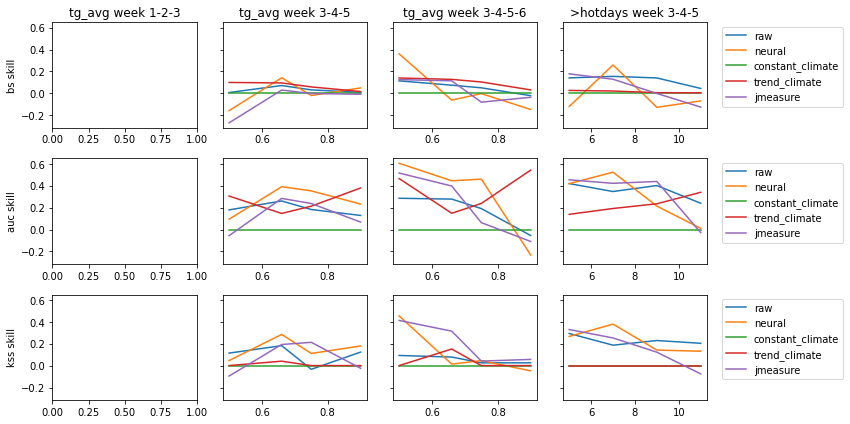

In [18]:
fig, axes = plt.subplots(nrows=3, ncols = 4, figsize = (12,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural','constant_climate','trend_climate','jmeasure'], index = ['pi','ppsf','climatology','trend','ppjm'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    if not ('ppsf' in plotframe.columns):
        plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(rankraw.columns.get_level_values('score').unique()):

    #plotranks(ax = axes[i,0], plotframe = rankraw.loc[:,(score,slice(None))]) # First raw tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,2], plotframe = ranktganom.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,3], plotframe = ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    #axes[i,1].plot()
    #axes[i,2].plot(ranktganom.loc[31,(score,slice(None))]) 
    #axes[i,3].plot(ranktgex.loc[:,(score,slice(None))]) # Then hotdays
    axes[i,3].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} skill')

axes[0,0].set_title('tg_avg week 1-2-3')
axes[0,1].set_title('tg_avg week 3-4-5')
axes[0,2].set_title('tg_avg week 3-4-5-6')
axes[0,3].set_title('>hotdays week 3-4-5')
plt.tight_layout()

A display of non-robustness is in the 21day median exceedence, where, in contrast to the 31day median exceedence, the raw is worse than the trend and therefore also the worst score is obtained.
* is this due to extensive overfitiing
* Or is there little correspondence in the predictability (by the raw) in the 21day and 31day median timeseries

We check the latter with correspondence measures:

In [73]:
from Hybrid.dataprep import default_prep, filter_predictor_set, PreparedData
import itertools

In [215]:
def compute_props(dataprep: PreparedData, focus_class:int = -1, seasonal: bool = False):
    """
    Creates a frame with trainval/test division, and 
    """
    def seasonal_transform(series:pd.Series):
        if seasonal:
            return series.groupby(series.index.get_level_values('time').year, axis = 0).mean()
        else:
            return series
    ftest = seasonal_transform(dataprep.crossval.forc_test.iloc[:,focus_class])
    otest = seasonal_transform(dataprep.crossval.obs_test.iloc[:,focus_class])
    ftrainval = seasonal_transform(dataprep.crossval.forc_trainval.iloc[:,focus_class])
    otrainval = seasonal_transform(dataprep.crossval.obs_trainval.iloc[:,focus_class])
    frame = pd.concat([ftest,otest,ftrainval,otrainval], axis = 1, keys = pd.MultiIndex.from_product([['test','trainval'],['forc','obs']]))
    return frame

def compute_measure(dataprep: PreparedData, focus_class:int = -1, nbins:int =  10, min_samples:int = 5):
    """
    Computes and returns jmeasures
    """
    kwargs = dict(return_measures= True, nbins = nbins, min_samples_per_bin = min_samples)
    _, jtest = filter_predictor_set(predset = dataprep.crossval.forc_test, observation = dataprep.crossval.obs_test.iloc[:,focus_class].astype(bool), **kwargs)
    _, jtrainval = filter_predictor_set(predset = dataprep.crossval.forc_trainval, observation = dataprep.crossval.obs_trainval.iloc[:,focus_class].astype(bool), **kwargs)
    _, jfull = filter_predictor_set(predset = dataprep.raw.forc, observation = dataprep.raw.obs.iloc[:,focus_class].astype(bool), **kwargs)
    return pd.Series([jtest.iloc[focus_class], jtrainval.iloc[focus_class], jfull.iloc[focus_class]], index = pd.Index(['test','trainval','full']))

reading full set, no objective selection
fitting a new feature scaler
using a pre-fitted feature scaler
reading full set, no objective selection
fitting a new feature scaler
using a pre-fitted feature scaler


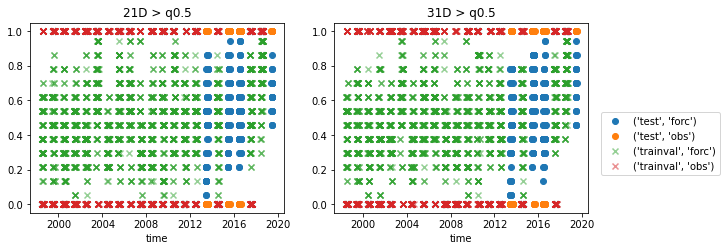

In [216]:
seasonal = False
timescales = [21,31]
preps = [default_prep(f'tg-anom_JJA_45r1_{scale}D-roll-mean_q0.5_sep12-15')[0] for scale in timescales]
props = [compute_props(prep, seasonal = seasonal) for prep in preps]
measures = [compute_measure(prep) for prep in preps]

fig, axes = plt.subplots(ncols = len(timescales), figsize = (10,3.5), squeeze=False)
for scale, key in itertools.product(timescales,props[0].columns):
    index = timescales.index(scale)
    if 'trainval' in key:
        axes[0,index].scatter(x = props[index].index.get_level_values(0), y = props[index][key], label = key, alpha = 0.5, marker = 'x')
    else:
        axes[0,index].scatter(x = props[index].index.get_level_values(0), y = props[index][key], label = key)
    axes[0,index].set_title(f'{scale}D > q0.5')
    axes[0,index].set_xlabel('time')
    
axes[0,-1].legend(loc = (1.05,0.2))
plt.show()

In Seasonal mean mode there is not much to see. Predictands seem very comparable indeed.

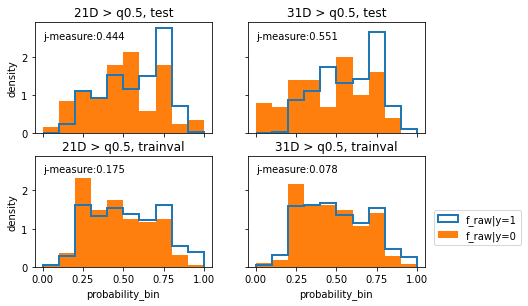

In [220]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (7,4.5), facecolor = 'white')

bins = np.arange(0,1.1,0.1)
for what, timescale in itertools.product(['test','trainval'],timescales):
    rowind = ['test','trainval'].index(what)
    colind = timescales.index(timescale)
    frame = props[colind][what]
    ax = axes[rowind,colind]
    ax.hist(frame['forc'].iloc[frame['obs'].astype(bool).values], label = 'f_raw|y=1', bins = bins, histtype = 'step', lw = 2, density = True)
    ax.hist(frame['forc'].iloc[~frame['obs'].astype(bool).values], label = 'f_raw|y=0', bins = bins, density = True)
    ax.set_title(f'{timescale}D > q0.5, {what}')
    ax.text(0.05,0.85,f'j-measure:{np.round(measures[colind][what],3)}',transform=ax.transAxes)

axes[0,0].set_ylabel('density')
axes[1,0].set_ylabel('density')
axes[1,0].set_xlabel('probability_bin')
axes[1,1].set_xlabel('probability_bin')
axes[1,1].legend(loc = (1.05,0.2))
plt.show()

The difference in j-measure value for the test set depends a bit on the min-samples. But overall we can conclude that the quality of the raw model is higher for the 31day forecasts, when looking at the test set.